In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#Evaluation
from sklearn.metrics import classification_report

#Models
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


In [2]:
#Load the dataset
df = pd.read_csv('players_data.csv')

print(df.head)

<bound method NDFrame.head of         userNum       nickname    gameId  seasonId  gameRank character  \
0       5426009             마샤  46678118        31         2     Cathy   
1       5296453         쿠로미여동생  46678118        31         1     Hisui   
2       5162955         우주생명마음  46678118        31         5     Adina   
3       5140049        只玩过卡拉彼丘  46678118        31         7    Ly Anh   
4       5051669        초고교급마다키  46678118        31         7   Tsubame   
...         ...            ...       ...       ...       ...       ...   
311260  1931832       Enakyira  48012635         0         2     Rozzi   
311261  1306446  eternalqueues  48012635         0         2    Camilo   
311262   396298            키므디  48012635         0         2    Celine   
311263   102184             다댜  48012635         0         1    Daniel   
311264    71827       억까를당하는사람  48012635         0         1      Yuki   

                  weapon                itemWeapon       itemChest  \
0          

In [3]:
traits = ['Trait_Main1', 'Trait_Main2', 'Trait_Sub1', 'Trait_Sub2']

#Count rows with any missing trait
null_trait = df[traits].isnull().any(axis=1).sum()

#Count total rows before dropping
all_rows = len(df)

#filled vs missing trait ratios
print(f"Total rows before dropping: {all_rows}")
print(f"Rows with missing traits: {null_trait} ({(null_trait / all_rows):.2%})")
print(f"Rows with all traits filled: {all_rows - null_trait} ({((all_rows - null_trait) / all_rows):.2%})")


Total rows before dropping: 311265
Rows with missing traits: 41064 (13.19%)
Rows with all traits filled: 270201 (86.81%)


In [4]:
ratio = df.isnull().mean().sort_values(ascending=False)
print("Missing values (top 10):\n", ratio.head(10))

#Drop rows
df.dropna(subset=['gameRank', 'Dmg_Player', 'Dmg_Monster','Trait_Main1', 'Trait_Main2', 'Trait_Sub1', 'Trait_Sub2'], inplace=True)


Missing values (top 10):
 Trait_Main2    0.131926
Trait_Main1    0.131926
Trait_Sub2     0.001645
Trait_Sub1     0.000469
nickname       0.000026
userNum        0.000000
Dmg_Player     0.000000
Assist         0.000000
Death          0.000000
Kill           0.000000
dtype: float64


In [5]:
print("Missing values:")
print(df.isnull().sum())


Missing values:
userNum        0
nickname       8
gameId         0
seasonId       0
gameRank       0
character      0
weapon         0
itemWeapon     0
itemChest      0
itemHead       0
itemArm        0
itemLeg        0
Trait_Main1    0
Trait_Main2    0
Trait_Sub1     0
Trait_Sub2     0
TeamKill       0
Kill           0
Death          0
Assist         0
Dmg_Player     0
Dmg_Monster    0
dtype: int64


In [6]:
#Merge Traits
df['AllTraits'] = df[['Trait_Main1', 'Trait_Main2', 'Trait_Sub1', 'Trait_Sub2']].agg('_'.join, axis=1)

#Bin gameRank into performance tiers
def placement_filter(rank):
    if rank <= 3:
        return 'Good'
    elif rank <= 6:
        return 'Average'
    else:
        return 'Bad'

df['BuildPerformance'] = df['gameRank'].apply(placement_filter)


In [7]:
df.head()

,userNum,nickname,gameId,seasonId,gameRank,character,weapon,itemWeapon,itemChest,itemHead,...,Trait_Sub1,Trait_Sub2,TeamKill,Kill,Death,Assist,Dmg_Player,Dmg_Monster,AllTraits,BuildPerformance
0,5426009,마샤,46678118,31,2,Cathy,Dagger,Asura,The_Revenant,Imperial_Crown,...,Coin_Toss,Penny_Pincher,5,0,3,5,12065,53392,Unwavering_Mentality_Cavalcade_Coin_Toss_Penny...,Good
1,5296453,쿠로미여동생,46678118,31,1,Hisui,Two-handed_Sword,Aurora_Longsword,Áo_Dài,Blaster_Helmet,...,Unwavering_Mentality,Cavalcade,17,5,4,7,15397,79563,Contempt_for_the_Weak_Anima_Reaper_Unwavering_...,Good
2,5162955,우주생명마음,46678118,31,5,Adina,Arcana,The_Moon,Blood_Cloak,Persona,...,Dismantle_Goliath,Anima_Reaper,19,12,2,6,36449,67664,Open_Wounds_Overwatch_Dismantle_Goliath_Anima_...,Average
3,5140049,只玩过卡拉彼丘,46678118,31,7,Ly Anh,Dagger,Maharaja,Dragon_Dobok,Cowboy_Hat,...,Painkiller,Dine_n'_Dash,10,0,3,6,6315,23338,Frenzy_Carnivore_Painkiller_Dine_n'_Dash,Bad
4,5051669,초고교급마다키,46678118,31,7,Tsubame,Shuriken,Petal_Torrent,Changpao,Crystal_Tiara,...,Unwavering_Mentality,Cavalcade,10,9,2,0,17556,50226,Dismantle_Goliath_Anima_Reaper_Unwavering_Ment...,Bad


In [8]:
#Features
Categorical = ['character', 'weapon', 'itemWeapon', 'itemChest', 'itemHead', 'itemArm', 'itemLeg', 'AllTraits']
Numerical = ['Kill', 'Assist', 'Death', 'TeamKill', 'Dmg_Player', 'Dmg_Monster']

#Target
target = 'BuildPerformance'


In [9]:
#Split dataset
X = df[Categorical + Numerical]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [10]:
#Build Preprocessing Pipeline

#Categorical pipeline
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

#Numerical pipeline
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

#Combine both pipelines
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_pipeline, Categorical),
    ('num', numerical_pipeline, Numerical)
])


In [11]:
#Old code, do not run. Very heavy. Uses all rows

#Model list
models = {
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "SVC": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Extra Trees": ExtraTreesClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(random_state=42)
}

#Results Dictionary
results = {}

for name, model in models.items():
    print(f"Evaluating {name}...")
    # Pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    
    #Cross validate.
    scores = cross_validate(
        pipeline,
        X_train,
        y_train,
        cv=5,
        scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
        return_train_score=False
    )
    
    #Results for [x] model
    results[name] = {
        'accuracy': (scores['test_accuracy'].mean(), scores['test_accuracy'].std()),
        'precision': (scores['test_precision_macro'].mean(), scores['test_precision_macro'].std()),
        'recall': (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std()),
        'f1': (scores['test_f1_macro'].mean(), scores['test_f1_macro'].std())
    }

#df
results_df = pd.DataFrame(results).T.sort_values(by='f1', ascending=False)

#Split metric
results_df[['accuracy_mean', 'accuracy_std']] = pd.DataFrame(results_df['accuracy'].to_list(), index=results_df.index)
results_df[['precision_mean', 'precision_std']] = pd.DataFrame(results_df['precision'].to_list(), index=results_df.index)
results_df[['recall_mean', 'recall_std']] = pd.DataFrame(results_df['recall'].to_list(), index=results_df.index)
results_df[['f1_mean', 'f1_std']] = pd.DataFrame(results_df['f1'].to_list(), index=results_df.index)

#Put in df
results_df = results_df.drop(columns=['accuracy', 'precision', 'recall', 'f1'])

#Print
print(results_df)


Evaluating Random Forest...


KeyboardInterrupt: 

In [22]:
#multiple model testing but lighter. Use this. Set sample size. <10k. Code above is stinky.
# Encode target for training
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Combine X_train and encoded y for safe sampling
train_df = X_train.copy()
train_df['label'] = y_train_encoded

# Sample from the training set
SAMPLE_SIZE = 8000
sampled_df = train_df.sample(n=SAMPLE_SIZE, random_state=42)

X_sampled = sampled_df.drop(columns='label')
y_sampled_encoded = sampled_df['label'].values

# Define models
models = {
    "Random Forest": RandomForestClassifier(n_jobs=-1, random_state=42, class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_jobs=-1, random_state=42),
    "XGBoost": XGBClassifier(n_jobs=-1, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(n_jobs=-1, random_state=42),
    "KNN": KNeighborsClassifier(n_jobs=-1),
}

results = {}

# Evaluate
for name, model in models.items():
    print(f"Evaluating {name}...")

    # Hyperparameter (play around)
    if name == "Random Forest":
        param_dist = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
        model = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=3, n_jobs=-1)

    if name == "Gradient Boosting":
        param_dist = {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
        model = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=3, n_jobs=-1)

    # Pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Cross-validation
    scores = cross_validate(
        pipeline,
        X_sampled,
        y_sampled_encoded,
        cv=3,
        scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
        return_train_score=False,
        n_jobs=-1,
        verbose=10
    )

    #Results
    results[name] = {
        'accuracy': (scores['test_accuracy'].mean(), scores['test_accuracy'].std()),
        'precision': (scores['test_precision_macro'].mean(), scores['test_precision_macro'].std()),
        'recall': (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std()),
        'f1': (scores['test_f1_macro'].mean(), scores['test_f1_macro'].std())
    }

#DF
results_df = pd.DataFrame(results).T.sort_values(by='f1', ascending=False)
results_df[['accuracy_mean', 'accuracy_std']] = pd.DataFrame(results_df['accuracy'].to_list(), index=results_df.index)
results_df[['precision_mean', 'precision_std']] = pd.DataFrame(results_df['precision'].to_list(), index=results_df.index)
results_df[['recall_mean', 'recall_std']] = pd.DataFrame(results_df['recall'].to_list(), index=results_df.index)
results_df[['f1_mean', 'f1_std']] = pd.DataFrame(results_df['f1'].to_list(), index=results_df.index)
results_df = results_df.drop(columns=['accuracy', 'precision', 'recall', 'f1'])

#print
print(results_df)

Evaluating Random Forest...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Evaluating Gradient Boosting...


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Evaluating Logistic Regression...


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Evaluating Decision Tree...


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Evaluating AdaBoost...


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Evaluating Extra Trees...


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Evaluating XGBoost...


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Evaluating LightGBM...


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Evaluating KNN...
                     accuracy_mean  accuracy_std  precision_mean  \
LightGBM                  0.705250      0.002757        0.704943   
Logistic Regression       0.703125      0.003732        0.701590   
Gradient Boosting         0.702500      0.008562        0.703449   
Random Forest             0.701124      0.006674        0.699661   
XGBoost                   0.701626      0.005564        0.701564   
Extra Trees               0.680376      0.007051        0.677181   
AdaBoost                  0.655493      0.039965        0.656786   
KNN                       0.646125      0.001651        0.645140   
Decision Tree             0.616500      0.005676        0.607057   

                     precision_std  recall_mean  recall_std   f1_mean  \
LightGBM                  0.004696     0.695306    0.001781  0.699564   
Logistic Regression       0.001830     0.695238    0.006477  0.698054   
Gradient Boosting         0.005928     0.690865    0.009369  0.696256   
Random Fo

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s finished


In [10]:
print(results_df)

                     accuracy_mean  accuracy_std  precision_mean  \
LightGBM                  0.705250      0.002757        0.704943   
Logistic Regression       0.703125      0.003732        0.701590   
Random Forest             0.702250      0.004451        0.699323   
Gradient Boosting         0.702125      0.008972        0.703105   
XGBoost                   0.701626      0.005564        0.701564   
Extra Trees               0.680376      0.007051        0.677181   
AdaBoost                  0.655493      0.039965        0.656786   
KNN                       0.646125      0.001651        0.645140   
Decision Tree             0.616500      0.005676        0.607057   

                     precision_std  recall_mean  recall_std   f1_mean  \
LightGBM                  0.004696     0.695306    0.001781  0.699564   
Logistic Regression       0.001830     0.695238    0.006477  0.698054   
Random Forest             0.002136     0.696310    0.006272  0.697624   
Gradient Boosting         0

Evaluating Random Forest...
Evaluating Gradient Boosting...
Evaluating Logistic Regression...
Evaluating Decision Tree...
Evaluating AdaBoost...
Evaluating Extra Trees...
Evaluating XGBoost...
Evaluating LightGBM...
Evaluating KNN...


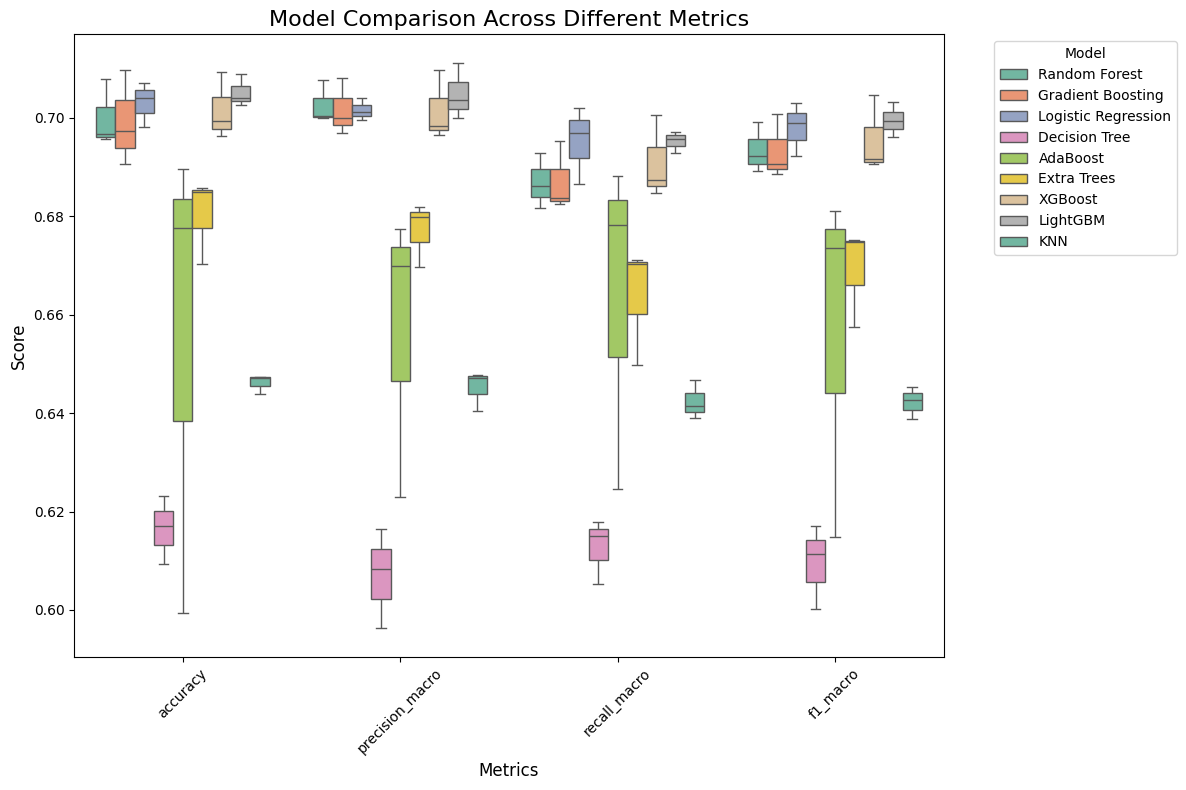

In [11]:
# Cross-validation results for box
cv_results = {
    'model': [],
    'metric': [],
    'score': []
}

#Cross again for box plot
for name, model in models.items():
    print(f"Evaluating {name}...")
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])

    # Cross-validation with sampling and parallel processing
    scores = cross_validate(
        pipeline,
        X_sampled,
        y_sampled_encoded,
        cv=3,  # 3-fold CV faster than 5 flod
        scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
        return_train_score=False,
        n_jobs=-1  # Parallel processing (OOoooo my pc...!)
    )

    # Collect scores
    for metric in ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']:
        cv_results['model'].extend([name] * 3)  # 3 folds
        cv_results['metric'].extend([metric] * 3)  # 3 folds
        cv_results['score'].extend(scores[f'test_{metric}'])  # 3 fold scores

# Convert to DataFrame
cv_results_df = pd.DataFrame(cv_results)

# Set up the figure and axes
plt.figure(figsize=(12, 8))

# Create the boxplot
sns.boxplot(x='metric', y='score', hue='model', data=cv_results_df, palette='Set2')

# Set titles and labels
plt.title('Model Comparison Across Different Metrics', fontsize=16)
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


In [12]:
#Final pipeline with chosen classifier
character_build = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', LGBMClassifier(n_jobs=-1, random_state=42))
])


In [21]:
#Train the model
character_build.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.410586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2495
[LightGBM] [Info] Number of data points in the train set: 216160, number of used features: 945
[LightGBM] [Info] Start training from score -0.953810
[LightGBM] [Info] Start training from score -1.523215
[LightGBM] [Info] Start training from score -0.924524


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['character', 'weapon',
                                                   'itemWeapon', 'itemChest',
                                                   'itemHead', 'itemArm',
                                                   'itemLeg', 'AllTraits']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Kill', 'Assist', 'Death',
                                                   'TeamKill', 'Dmg_Player',
                                                   'Dmg_Monster'])])),
                ('classifier', LGBMClassifier(n_jobs=-1, random_state=42))])

1463 1463
                                                Feature  Importance
1462                                   num__Dmg_Monster         934
1460                                      num__TeamKill         545
1459                                         num__Death         504
1461                                    num__Dmg_Player         377
1458                                        num__Assist         308
...                                                 ...         ...
757   cat__AllTraits_Circular_System_R_echarger_Cont...           0
758   cat__AllTraits_Circular_System_R_echarger_Dism...           0
759   cat__AllTraits_Circular_System_R_echarger_Dism...           0
760   cat__AllTraits_Circular_System_R_echarger_Embo...           0
731   cat__AllTraits_Circular_System_Overwatch_Paink...           0

[1463 rows x 2 columns]


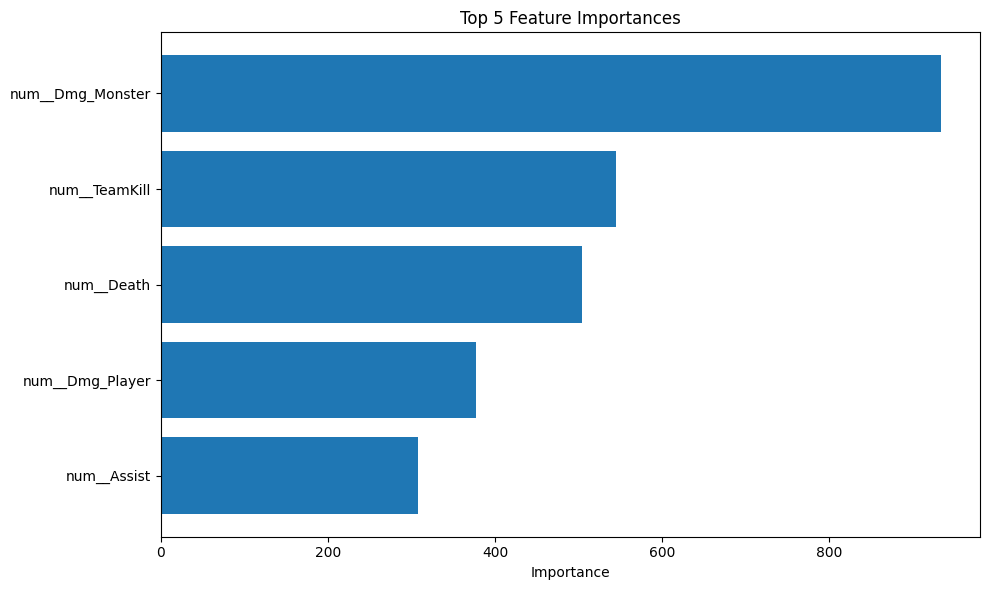

In [50]:
# Get feature importances from the trained model
importances = character_build.named_steps['classifier'].feature_importances_

# After preprocessing, get the feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

# Check the number of features in feature_names and importances
print(len(feature_names), len(importances))
importances = importances[:len(feature_names)]


# Pair the importances with feature names for easier interpretation
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display feature importance
print(feature_importance_df)

# Get the top 10 most important features
top_n = 5
top_features = feature_importance_df.head(top_n)

# Plot the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.title(f'Top {top_n} Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.tight_layout()
plt.show()


In [ ]:
y_score = character_build.predict_proba(X_test)

In [27]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)  # or y_train / y_test


In [28]:
print(encoder.classes_)


['Average' 'Bad' 'Good']


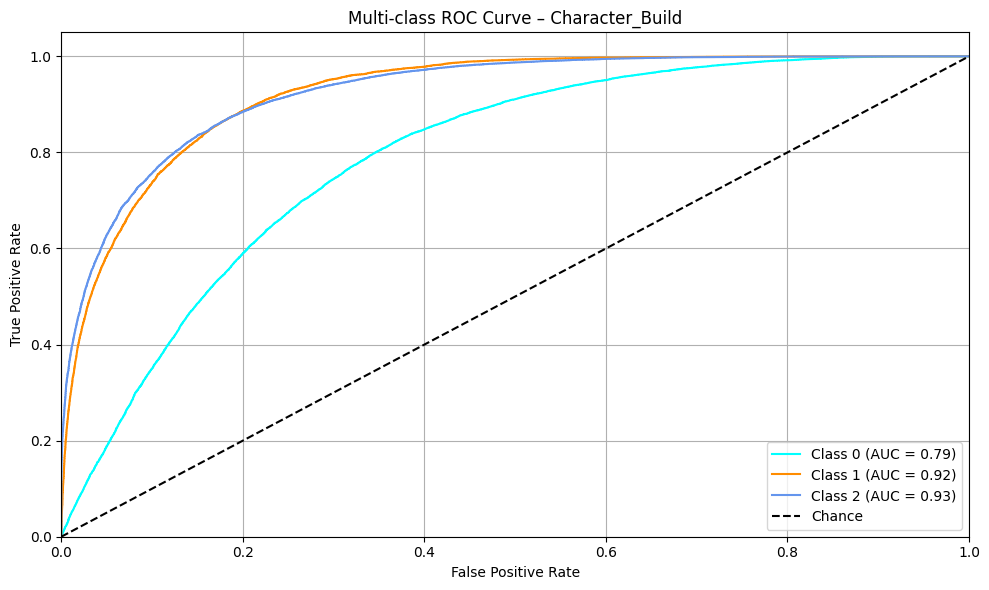

In [29]:
from sklearn.preprocessing import label_binarize
import numpy as np
from sklearn.metrics import roc_curve, auc

# Binarize the output for multi-class ROC
y_test_binarized = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_binarized.shape[1]

from itertools import cycle

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'gray'])
plt.figure(figsize=(10, 6))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve – Character_Build')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
#Evaluate the model
y_pred = character_build.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

     Average       0.63      0.68      0.65     20820
         Bad       0.73      0.64      0.68     11782
        Good       0.81      0.80      0.80     21439

    accuracy                           0.72     54041
   macro avg       0.72      0.71      0.71     54041
weighted avg       0.72      0.72      0.72     54041



In [52]:
def Build_test(character_name, top_n=1, display=True):

    chara = df[df['character'] == character_name]

    if chara.empty:
        print(f"No data found for character: {character_name}")
        return []

    top_builds = chara[chara['gameRank'] <= 3]

    if top_builds.empty:
        print(f"No high-performing builds found for {character_name}. Showing best available instead.")
        top_builds = chara.sort_values(by='gameRank', ascending=True).head(top_n)
    else:
        top_builds = top_builds.sort_values(by='gameRank', ascending=True).head(top_n)

    builds = []
    for idx, (_, row) in enumerate(top_builds.iterrows(), start=1):
        build = {   
            "ItemWeapon": row['itemWeapon'],
            "ItemChest": row['itemChest'],
            "ItemHead": row['itemHead'],
            "ItemArm": row['itemArm'],
            "ItemLeg": row['itemLeg'],
            "Traits": [row['Trait_Main1'], row['Trait_Main2'], row['Trait_Sub1'], row['Trait_Sub2']]
        }
        builds.append(build)

        if display:
            print(f"\nRecommended Build #{idx} for {character_name}:")
            print(f"ItemWeapon  : {build['ItemWeapon']}")
            print(f"ItemChest   : {build['ItemChest']}")
            print(f"ItemHead    : {build['ItemHead']}")
            print(f"ItemArm     : {build['ItemArm']}")
            print(f"ItemLeg     : {build['ItemLeg']}")
            print("Traits      : " + ", ".join(build['Traits']))


In [53]:
Build_test("Istvan", top_n=3)



Recommended Build #1 for Istvan:
ItemWeapon  : Spear_of_Longinus_-_Dawn
ItemChest   : Burgundy_47
ItemHead    : Laurel_Wreath
ItemArm     : Auto-arms
ItemLeg     : Blade_Boots
Traits      : Contempt_for_the_Weak, Anima_Reaper, Embolden, Cavalcade

Recommended Build #2 for Istvan:
ItemWeapon  : Spear_of_Longinus
ItemChest   : Omertà
ItemHead    : Crusader_Helmet
ItemArm     : Auto-arms
ItemLeg     : Blade_Boots
Traits      : Contempt_for_the_Weak, Anima_Reaper, Embolden, Cavalcade

Recommended Build #3 for Istvan:
ItemWeapon  : Spear_of_Longinus_-_Crimson
ItemChest   : Racing_Suit
ItemHead    : Chinese_Opera_Mask
ItemArm     : Bloodripper
ItemLeg     : Boots_of_Hermes
Traits      : Painkiller, Dine_n'_Dash, Stopping_Power, R_echarger
